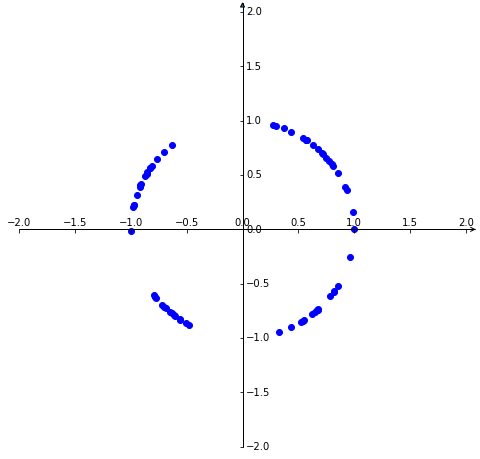

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 0 1 1 1]


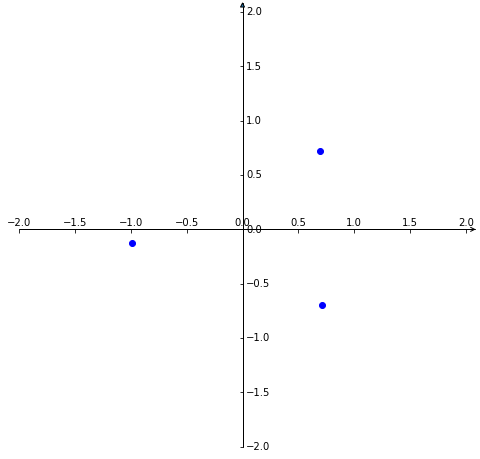

[[ 0.71622694 -0.69786744]
 [ 0.69005645  0.72375555]
 [-0.99231829 -0.12371104]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 2 1 1 1]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True])

In [4]:
#encoding=utf-8

import numpy as np
from Bio.Cluster import *
from numpy import linalg as LA
import mpl_toolkits.axisartist as axisartist
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from spherecluster import SphericalKMeans


class SphereCluster(object):
    def __init__(self, num_cluster=3):
        self.name = "SphereCluster"
        self.ncluster=num_cluster
        self.clusters = []
        self.main_id = 0
        self.mean = None
    
    def l2norm(self, data, axies=0, mean=None):
        process_data = normalize(data, norm="l2")
        return process_data

    def fit(self, data, norm=False, mean=None):
        '''
        Args:
            data numpy.ndarray: [m, n] m samples every sample with n dimention
            norm boolean: False as default, 
        '''
        if not norm:
            self.mean = np.mean(data, axis=0)
            process_data = self.l2norm(data-self.mean)
        else:
            process_data = data
            self.mean = mean

        clusterid, error, nfound = kcluster(process_data, nclusters=self.ncluster, dist="u")

        result = {}
        scores = []
        print(clusterid)
        self.clusters = []
        for i in range(self.ncluster):
            label = np.where(clusterid==i)[0].tolist()
            cluster_data = process_data[label,:]
            cluster = np.mean(cluster_data, axis=0)
            cluster = normalize(cluster.reshape(1,cluster.shape[0]), norm='l2')
            result[i]=cluster
            self.clusters.append(cluster)

            score = np.mean(np.dot(cluster_data, cluster.T))
            scores.append(score)
        
        self.clusters = np.vstack(self.clusters)
        self.main_id = np.argmax(scores)

        return result, clusterid, self.main_id

    def predict(self, data):
        '''
        Args:
            data numpy.ndarray: shape [n, c, h, w]
        return:
            labeled numpy.ndarray: shape [n, 1, h, w]
        '''
        #reshape [n,c,h,w]->[n*h*w, c]
        n, c, h, w = data.shape
        process_data = data.transpose(1,0,2,3)
        process_data = process_data.reshape(-1, process_data.shape[0])
        process_data -= self.mean
        process_data = self.l2norm(process_data)

        #label all vectors
        dist_matrix = np.dot(process_data,self.clusters.T)
        labeled = np.argmax(dist_matrix, axis=1)

        # reshape to origin [n*h*w, c]->[n, h, w]
        labeled = labeled.reshape(n, h, w)

        return labeled

def draw_xys(points):
    
    #创建画布
    fig = plt.figure(figsize=(8, 8))
    #使用axisartist.Subplot方法创建一个绘图区对象ax
    ax = axisartist.Subplot(fig, 111)  
    #将绘图区对象添加到画布中
    fig.add_axes(ax)

    #通过set_visible方法设置绘图区所有坐标轴隐藏
    ax.axis[:].set_visible(False)

    #ax.new_floating_axis代表添加新的坐标轴
    ax.axis["x"] = ax.new_floating_axis(0,0)
    #给x坐标轴加上箭头
    ax.axis["x"].set_axisline_style("->", size = 1.0)
    #添加y坐标轴，且加上箭头
    ax.axis["y"] = ax.new_floating_axis(1,0)
    ax.axis["y"].set_axisline_style("-|>", size = 1.0)
    #设置x、y轴上刻度显示方向
    ax.axis["x"].set_axis_direction("top")
    ax.axis["y"].set_axis_direction("right")
    #生成x步长为0.1的列表数据
    x = np.arange(-15,15,2)
    #生成sigmiod形式的y数据
    y=1/(1+np.exp(-x))
    #设置x、y坐标轴的范围
    plt.xlim(-2,2)
    plt.ylim(-2, 2)
    #绘制图形

    plt.scatter(points[:,0],points[:,1],c='b')
    plt.show()


# data = np.array(range(2*512*4*4),dtype=np.float32)
# data = data.reshape(2,512,4,4)


data = np.load("./data/points.npy")
mean = np.mean(data,axis=0)
centered = data-mean
norm_data = normalize(centered, norm='l2')

draw_xys(norm_data)


SC = SphereCluster()
# flatend_data = data.transpose(1,0,2,3)
# flatend_data = flatend_data.reshape(-1, flatend_data.shape[0])

result, clusterid,_ = SC.fit(norm_data, norm=True, mean=mean)

clusters = SC.clusters

clusters

draw_xys(clusters)

skm = SphericalKMeans(n_clusters=3)
skm.fit(norm_data)
clusters_bio=skm.cluster_centers_
print(clusters)
print(skm.labels_)

clusterid == skm.labels_
# SC.predict(data)


In [4]:
import numpy as np
co_var_matrix=np.load("./data/co_var_matrix.npy")
co_var_matrix


array([[ 1.42479803e-02, -5.65448255e-05, -9.73175703e-05, ...,
        -1.21167030e-05,  0.00000000e+00, -2.66988219e-03],
       [-5.65448255e-05,  1.98167550e-03,  3.74501141e-04, ...,
        -6.99277482e-06,  0.00000000e+00, -1.54083870e-03],
       [-9.73175703e-05,  3.74501141e-04,  5.41351188e-03, ...,
        -1.20350509e-05,  0.00000000e+00, -2.65189038e-03],
       ...,
       [-1.21167030e-05, -6.99277482e-06, -1.20350509e-05, ...,
         2.54810361e-04,  0.00000000e+00, -3.30178487e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.66988219e-03, -1.54083870e-03, -2.65189038e-03, ...,
        -3.30178487e-04,  0.00000000e+00,  7.43142237e-01]])

In [19]:
from spherecluster import SphericalKMeans
from sklearn.preprocessing import normalize
import numpy as np
import mpl_toolkits.axisartist as axisartist
import matplotlib.pyplot as plt

def draw_xys(points):
    
    #创建画布
    fig = plt.figure(figsize=(8, 8))
    #使用axisartist.Subplot方法创建一个绘图区对象ax
    ax = axisartist.Subplot(fig, 111)  
    #将绘图区对象添加到画布中
    fig.add_axes(ax)

    #通过set_visible方法设置绘图区所有坐标轴隐藏
    ax.axis[:].set_visible(False)

    #ax.new_floating_axis代表添加新的坐标轴
    ax.axis["x"] = ax.new_floating_axis(0,0)
    #给x坐标轴加上箭头
    ax.axis["x"].set_axisline_style("->", size = 1.0)
    #添加y坐标轴，且加上箭头
    ax.axis["y"] = ax.new_floating_axis(1,0)
    ax.axis["y"].set_axisline_style("-|>", size = 1.0)
    #设置x、y轴上刻度显示方向
    ax.axis["x"].set_axis_direction("top")
    ax.axis["y"].set_axis_direction("right")
    #生成x步长为0.1的列表数据
    x = np.arange(-15,15,2)
    #生成sigmiod形式的y数据
    y=1/(1+np.exp(-x))
    #设置x、y坐标轴的范围
    plt.xlim(-2,2)
    plt.ylim(-2, 2)
    #绘制图形

    plt.scatter(points[:,0],points[:,1],c='b')
    plt.show()
    
data = np.load("./data/points.npy")
centered = data-np.mean(data,axis=0)
norm_data = normalize(centered, norm='l2')

skm = SphericalKMeans(n_clusters=3)
skm.fit(norm_data)
clusters=skm.cluster_centers_
print(clusters)
print(skm.labels_)
print(skm.inertia_)

labels_bio = np.array([])
#draw_xys(clusters)

[[ 0.71585712  0.69824679]
 [-0.99231829 -0.12371104]
 [ 0.68179722 -0.73154122]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 0 0 0]
17.08649031756409


In [20]:
clusters


array([[ 0.71585712,  0.69824679],
       [-0.99231829, -0.12371104],
       [ 0.68179722, -0.73154122]])

In [21]:
dist_matrix = np.argmax(np.dot(norm_data, clusters.T),axis=1)

In [22]:
dist_matrix

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0,
       0])

In [3]:
dist_matrix==skm.labels_
draw_xys(clusters)
draw_xys(norm_data)

NameError: name 'dist_matrix' is not defined